In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the .xlsx file
df = pd.read_excel('/content/drive/My Drive/Final DataSet/sagu_data.xlsx')

# One-hot encode the 'Category' column into separate columns
one_hot_df = pd.get_dummies(df['Category'], prefix='Category')
df = pd.concat([df, one_hot_df], axis=1)

# Split data into features and target
X = df['Images'].values
y = one_hot_df.values

# Split the data into training and test sets (85% train, 15% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=df['Category'], random_state=42)

# Set image size and batch size
img_size = (299, 299)
batch_size = 32

# Initialize InceptionV3 model for feature extraction
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
feature_model = tf.keras.Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))
feature_model.trainable = False

# Preprocessing function for images
def preprocess_image(file_path):
    img = tf.keras.preprocessing.image.load_img(file_path.numpy().decode('utf-8'), target_size=img_size)
    img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    return img

def preprocess_image_with_py_func(file_path):
    img = tf.py_function(preprocess_image, [file_path], tf.float32)
    img.set_shape(img_size + (3,))
    return img

def prepare_dataset(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.map(lambda x, y: (preprocess_image_with_py_func(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Prepare train and test datasets
train_dataset = prepare_dataset(X_train, y_train)
test_dataset = prepare_dataset(X_test, y_test)

# Extract features in batches using InceptionV3
def extract_features_in_batches(dataset, model):
    features = []
    for batch in dataset:
        x_batch, _ = batch
        batch_features = model.predict(x_batch)
        features.append(batch_features)
    return np.concatenate(features)

train_features = extract_features_in_batches(train_dataset, feature_model)
test_features = extract_features_in_batches(test_dataset, feature_model)

import numpy as np

# Save extracted features and labels to drive for reuse
inception_train_features_path = '/content/drive/My Drive/Final DataSet/inception_train_features.npy'
inception_test_features_path = '/content/drive/My Drive/Final DataSet/inception_test_features.npy'
train_labels_path = '/content/drive/My Drive/Final DataSet/train_labels.npy'
test_labels_path = '/content/drive/My Drive/Final DataSet/test_labels.npy'

# Save the features and labels
np.save(inception_train_features_path, train_features)
np.save(inception_test_features_path, test_features)
np.save(train_labels_path, np.argmax(y_train, axis=1))
np.save(test_labels_path, np.argmax(y_test, axis=1))

print(f"InceptionV3 features and labels saved successfully:\n"
      f"- Train features: {inception_train_features_path}\n"
      f"- Test features: {inception_test_features_path}\n"
      f"- Train labels: {train_labels_path}\n"
      f"- Test labels: {test_labels_path}")


# Train a Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(train_features, np.argmax(y_train, axis=1))

# Make predictions on the test set
y_pred = log_reg.predict(test_features)

# Calculate and print classification report
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=one_hot_df.columns))




87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/st

Training Set Classification Report:
                        precision    recall  f1-score   support

         Category_Wood       1.00      1.00      1.00      2089
    Category_cardboard       1.00      1.00      1.00      2331
      Category_e-waste       1.00      1.00      1.00      2044
        Category_glass       1.00      1.00      1.00      2140
      Category_medical       1.00      1.00      1.00      2289
        Category_metal       1.00      1.00      1.00      1920
Category_organic_waste       1.00      1.00      1.00      2113
        Category_paper       1.00      1.00      1.00      2337
      Category_plastic       1.00      1.00      1.00      2224
     Category_textiles       1.00      1.00      1.00      2117

              accuracy                           1.00     21604
             macro avg       1.00      1.00      1.00     21604
          weighted avg       1.00      1.00      1.00     21604

Training Accuracy: 1.00


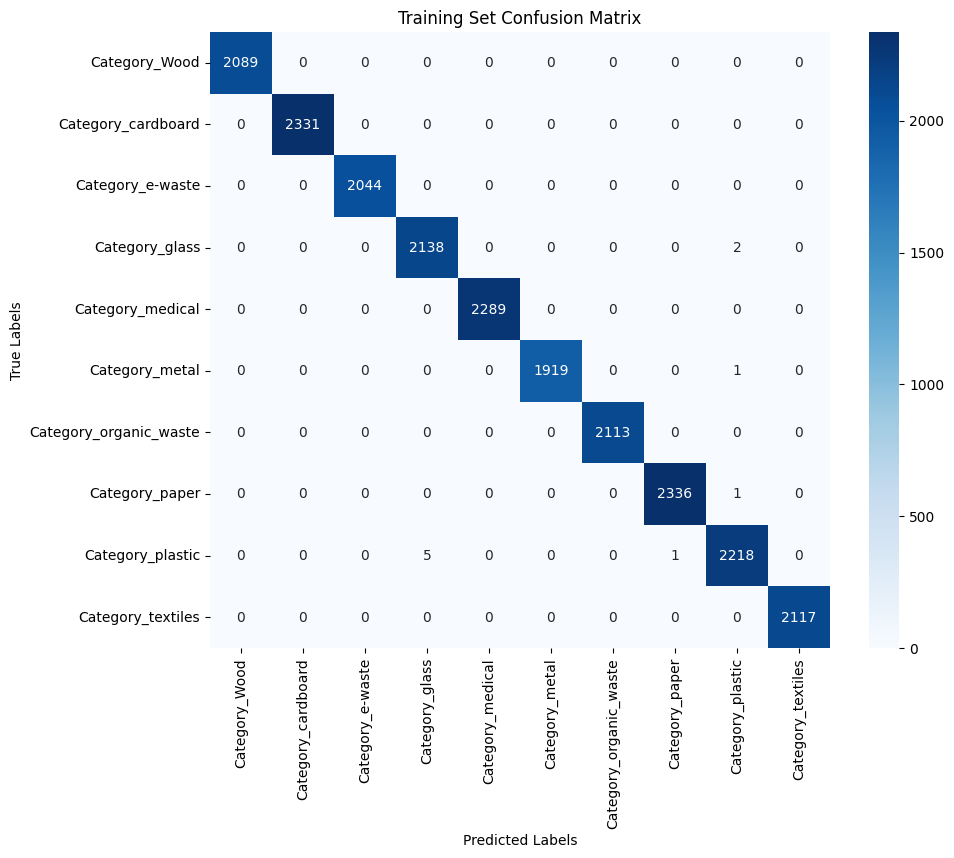

Test Set Classification Report:
                        precision    recall  f1-score   support

         Category_Wood       0.98      0.99      0.99       369
    Category_cardboard       0.89      0.90      0.89       411
      Category_e-waste       0.90      0.91      0.90       361
        Category_glass       0.87      0.85      0.86       378
      Category_medical       0.92      0.92      0.92       404
        Category_metal       0.82      0.80      0.81       339
Category_organic_waste       1.00      0.99      0.99       373
        Category_paper       0.85      0.88      0.87       412
      Category_plastic       0.81      0.80      0.80       393
     Category_textiles       0.99      0.99      0.99       373

              accuracy                           0.90      3813
             macro avg       0.90      0.90      0.90      3813
          weighted avg       0.90      0.90      0.90      3813

Test Accuracy: 0.90


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the training set
y_train_pred = log_reg.predict(train_features)

# Generate and print the classification report for the training set
print("Training Set Classification Report:")
print(classification_report(np.argmax(y_train, axis=1), y_train_pred, target_names=one_hot_df.columns))

# Calculate and print the training accuracy
train_accuracy = accuracy_score(np.argmax(y_train, axis=1), y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Generate and display the confusion matrix for the training set
train_conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), y_train_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=one_hot_df.columns, yticklabels=one_hot_df.columns)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Training Set Confusion Matrix")
plt.show()

# Make predictions on the test set
y_test_pred = log_reg.predict(test_features)

# Generate and print the classification report for the test set
print("Test Set Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_test_pred, target_names=one_hot_df.columns))

# Calculate and print the test accuracy
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")





# **With Saved features**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Features and labels loaded successfully!


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Train Accuracy: 1.00
Test Accuracy: 0.90

Train Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2089
           1       1.00      1.00      1.00      2331
           2       1.00      1.00      1.00      2044
           3       1.00      1.00      1.00      2140
           4       1.00      1.00      1.00      2289
           5       1.00      1.00      1.00      1920
           6       1.00      1.00      1.00      2113
           7       1.00      1.00      1.00      2337
           8       1.00      1.00      1.00      2224
           9       1.00      1.00      1.00      2117

    accuracy                           1.00     21604
   macro avg       1.00      1.00      1.00     21604
weighted avg       1.00      1.00      1.00     21604


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       369
           1       0.89

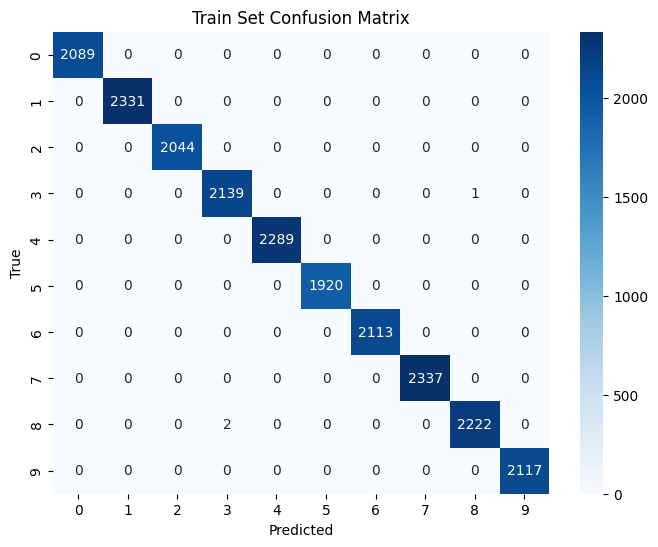


Test Set Confusion Matrix:


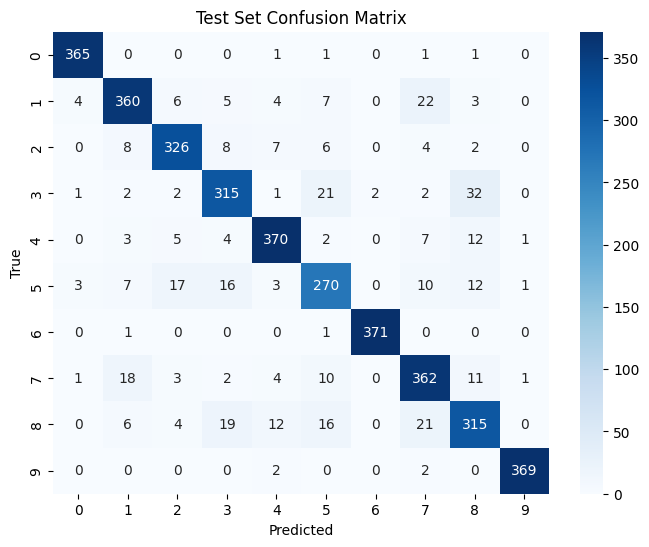

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to load the saved features and labels
inception_train_features_path = '/content/drive/My Drive/Final DataSet/inception_train_features.npy'
inception_test_features_path = '/content/drive/My Drive/Final DataSet/inception_test_features.npy'
train_labels_path = '/content/drive/My Drive/Final DataSet/train_labels.npy'
test_labels_path = '/content/drive/My Drive/Final DataSet/test_labels.npy'

# Load the pre-extracted features and labels
X_train = np.load(inception_train_features_path)
X_test = np.load(inception_test_features_path)
y_train = np.load(train_labels_path)
y_test = np.load(test_labels_path)

print("Features and labels loaded successfully!")

# Scale the features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression classifier
log_reg_model = LogisticRegression(max_iter=1000, random_state=42, C=1.0, solver='lbfgs', multi_class='multinomial')  # Adjust parameters if needed
log_reg_model.fit(X_train_scaled, y_train)

# Evaluate on train and test sets
y_train_pred = log_reg_model.predict(X_train_scaled)
y_test_pred = log_reg_model.predict(X_test_scaled)

# Print performance metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nTrain Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

print("\nTrain Set Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrices
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Display Confusion Matrices
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

print("\nTrain Set Confusion Matrix:")
plot_confusion_matrix(train_conf_matrix, "Train Set Confusion Matrix")

print("\nTest Set Confusion Matrix:")
plot_confusion_matrix(test_conf_matrix, "Test Set Confusion Matrix")
